In [1]:
# import packages
import geopandas as gpd
import pandas as pd
import pandana
import momepy
import matplotlib.pyplot as plt
import seaborn as sns

import contextily
import plotly.express as px
from ipyleaflet import Map, GeoJSON, GeoData, basemaps, LayersControl
from matplotlib_scalebar.scalebar import ScaleBar

## Data loading

In [42]:
# load data

pois = gpd.read_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/pois.gpkg')
parks = gpd.read_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/greenspaces_access.gpkg')
tessellation = gpd.read_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/results/tessellation.gpkg')
walk_streets = gpd.read_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/walk_streets.gpkg')


## Data cleaning

In [44]:
## clean data

# clean street network
walk_streets = walk_streets[["geometry", "from", "to", "length"]] # clean columns

# tessels centroids
tessels_centroid = tessellation[['uID','geometry']]
tessels_centroid['geometry'] = tessels_centroid.geometry.centroid

# clean pois
pois = pois.explode().reset_index(drop=True) # avoid multipart pois

amenities = ['Bakeries','Butchers','Confectioners','Delicatessens','Fishmongers','Grocers, Farm Shops and Pick Your Own','Convenience Stores and Independent Supermarkets','Supermarket Chains',
             'Bus Stops','Railway Stations, Junctions and Halts',
             'Gymnasiums, Sports Halls and Leisure Centres','Sport and Entertainment'
             'Higher Education Establishments','First, Primary and Infant Schools','Broad Age Range and Secondary State Schools',
             'Doctors Surgeries','Hospitals','Chemists and Pharmacies',
             'Cinemas','Theatres and Concert Halls','Art Galleries'] # select which amenities to keep
pois_filtered = pois[pois.classname.isin(amenities)] # filter amenities
pois_filtered = pois_filtered[['groupname','categoryname','classname','geometry']] # clean columns
pois_filtered['poiID'] = range(0,len(pois_filtered)) # generate index column
pois_filtered = pois_filtered.set_index('poiID') # set index column

# parks
parks = parks.reset_index(drop=True).explode().reset_index(drop=True) # clean
parks['parksID'] = range(0,len(parks)) # generate index column
parks = parks.set_index('parksID') # set index

# join pois and parks
df_list = [pois_filtered, parks]
destinations = gpd.GeoDataFrame(pd.concat(df_list, ignore_index=True))
destinations = destinations.reset_index().rename(columns={'index':'poiID'}) # set a unique ID for each poi
destinations = destinations.to_crs(27700)

C:\Users\b9066009\AppData\Local\Temp\ipykernel_70492\3204346384.py:11: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  pois = pois.explode().reset_index(drop=True) # avoid multipart pois
C:\Users\b9066009\AppData\Local\Temp\ipykernel_70492\3204346384.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  parks = parks.reset_index(drop=True).explode().reset_index(drop=True) # clean


In [ ]:
# # save clean data
# walk_streets.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/walk_streets.gpkg', layer = 'walk_streets_clean', driver='GPKG')
# postcodes.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/postcodes.gpkg', layer = 'postcodes_clean', driver='GPKG')
# pois.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/pois.gpkg', layer = 'pois_clean', driver='GPKG')
# parks.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/parks.gpkg', layer = 'parks_clean', driver='GPKG')
# destinations.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/data/destinations.gpkg', layer = 'destinations', driver='GPKG')

## Pandana network

In [4]:
## generate pandana network
# nodes and edges for walk network
nodes_walk, edges_walk = momepy.nx_to_gdf( # convert network to gdf
    momepy.gdf_to_nx( # convert to nx graph
        walk_streets.explode() # remove multipart rows
    )
)
nodes_walk = nodes_walk.set_index('nodeID') # set index

# generate walk pandana network
walk_streets_pdna = pandana.Network( 
    nodes_walk.geometry.x,
    nodes_walk.geometry.y,
    edges_walk['node_start'], # set origins
    edges_walk['node_end'], # set destinations
    edges_walk[['mm_len']] # set edge length
)

C:\Users\b9066009\AppData\Local\Temp\ipykernel_70492\1369973530.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  walk_streets.explode() # remove multipart rows


### Analysis for adults

In [18]:
# attach pois to the network
walk_streets_pdna.set_pois( # snap pois to network
    category = 'destinations_adults', # set name of the new layer snapped on the network
    maxdist = 1125, # set maximum distance
    maxitems = 700, # set maximum number of pois to look for
    x_col = destinations.geometry.x,
    y_col = destinations.geometry.y
)

results_adults = walk_streets_pdna.nearest_pois( # calculate distances to pois
    distance = 1125, # maximum distance
    category = 'destinations_adults', # layer where we want to look for
    num_pois = 700, # max number of pois to look for
    include_poi_ids = True # include pois ids
)

# separate distances from poi ids
distances_adults = results_adults.iloc[:,:round(len(results_adults.columns)/2,)] # create df with distances
pois_ids_adults = results_adults.iloc[:,round(len(results_adults.columns)/2,):] # create df with pois ids

# convert wide matrices to long
distances_long_adults = pd.melt(distances_adults.reset_index(), id_vars='nodeID', value_name='distance')[['nodeID','distance']] # make matrix long
pois_ids_long_adults = pd.melt(pois_ids_adults.reset_index(), id_vars='nodeID', value_name='poiID')[['nodeID','poiID']] # make matrix long

# create an od long df containing nodeID, distance, and poiID
od_adults = distances_long_adults
od_adults['poiID'] = pois_ids_long_adults['poiID'].astype('Int64') # set a column with pois ids (as they are indexed, they are already in the right order)

# format od matrix and drop NAs
od_adults = od_adults.dropna() # drop NAs

# add destinations' info
od_pois_info_adults = pd.merge(od_adults,destinations)

# keep unique parks ids
od_pois_info_adults = od_pois_info_adults.drop_duplicates(
    subset=['nodeID','refToGreenspaceSite'],
    keep='last'
).reset_index(drop=True)

## re-structure od
# separate parks from rest of pois
od_pois_info_adults.loc[od_pois_info_adults['id'].notnull(), ['groupname','categoryname','classname']] = 'Park'
od_pois_info_adults = od_pois_info_adults.drop(columns=['id','accessType','refToGreenspaceSite','geometry'])

# add nodes and pois geometries
od_pois_info_adults = pd.merge(od_pois_info_adults, nodes_walk, left_on='nodeID', right_on='nodeID')
od_pois_info_adults = od_pois_info_adults.rename(columns={'geometry':'geometry_nodes'})

od_pois_info_adults = pd.merge(od_pois_info_adults,destinations[['poiID','geometry']],left_on='poiID',right_on='poiID')
od_pois_info_adults = od_pois_info_adults.rename(columns={'geometry':'geometry_pois'})

# add postcodes
tessels_centroid['nodeID'] = walk_streets_pdna.get_node_ids(tessels_centroid.geometry.x, tessels_centroid.geometry.y)
tessels_centroid = tessels_centroid.reset_index()
od_pois_info_adults = pd.merge(od_pois_info_adults, tessels_centroid)

# conver to gdf and save
od_pois_info_adults = gpd.GeoDataFrame(od_pois_info_adults, geometry='geometry').set_crs(27700)
#od_pois_info_adults.to_csv('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/od_adults.csv', index=False)


In [13]:
# number of amenities accessible per postcode
n_accessible = pd.DataFrame(od_pois_info_adults.groupby('uID').poiID.nunique()).reset_index().rename(columns={'poiID':'count'})

# variety of amenities accessible per postcode
v_accessible = pd.DataFrame(od_pois_info_adults.groupby('uID').classname.nunique()).reset_index().rename(columns={'classname':'variety'})

# minimum distance to each category from each postcode
min_dist_classname = pd.DataFrame(od_pois_info_adults.groupby(['uID','classname']).distance.min()).reset_index().rename(columns={'distance':'min_dist'})

# average distance to all categories from each postcode
avg_dist = pd.DataFrame(od_pois_info_adults.groupby('uID').distance.mean()).reset_index().rename(columns={'distance':'avg_dist'})

# average distance to each category from each postcode
avg_dist_classname = pd.DataFrame(od_pois_info_adults.groupby(['uID','classname']).distance.mean()).reset_index().rename(columns={'distance':'avg_dist'})

In [19]:
## calculate dimension index
index = pd.DataFrame(od_pois_info_adults['uID'].unique()).rename(columns={0:'uID'})

# for number of amenities
n_accessible['n_accessible_index'] = (n_accessible['count'] - min(n_accessible['count'])) / (max(n_accessible['count']) - min(n_accessible['count']))

# for variety of amenities
v_accessible['v_accessible_index'] = (v_accessible['variety'] - min(v_accessible['variety'])) / (max(v_accessible['variety']) - min(v_accessible['variety']))

# for average distance
avg_dist['avg_dist_index'] = (avg_dist['avg_dist'] - min(avg_dist['avg_dist'])) / (max(avg_dist['avg_dist']) - min(avg_dist['avg_dist']))

## calculate composite index
index = pd.merge(index,n_accessible[['uID','n_accessible_index']])
index = pd.merge(index,v_accessible[['uID','v_accessible_index']])
index = pd.merge(index,avg_dist[['uID','avg_dist_index']])

# index
index['access_score'] = ((index['n_accessible_index'] * index['v_accessible_index']) / (index['avg_dist_index'] + 1)).pow(1/3)

# add accessibility index info to postcodes
tessels_access_adults = pd.merge(tessels_centroid, index)

#postcodes_access_adults.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/gisruk_2022/results/results.gpkg', layer = 'index_adults', driver = 'GPKG')

In [24]:
test.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/results/tessellation_access.gpkg')

In [60]:
# merge access score to tessels
access_score_adults_tessels = pd.merge(tessellation,test[['uID_left','access_score']], left_on='uID',right_on='uID_left')

In [61]:
access_score_adults_tessels.to_file('C:/Users/b9066009/Documents/PhD/conferences/2022_GISRUK/2022_gisruk/2022_gisruk/results/tessellation_access.gpkg')

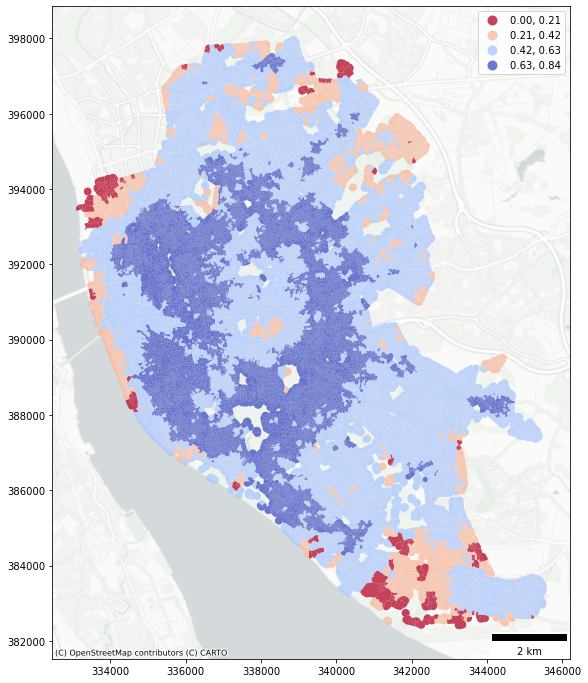

In [70]:
# generate static map
fig, ax1 = plt.subplots(figsize=(12,12))

ax1 = access_score_adults_tessels.plot(
    ax=ax1,
    column='access_score',
    scheme='equal_interval',
    k=4,
    cmap='coolwarm_r',
    markersize=(1),
    alpha=0.75,
    legend=True
)

#ax1.set_axis_off()
ax1.add_artist(ScaleBar(1,location='lower right'))
contextily.add_basemap(ax1, crs=access_score_adults_tessels.crs.to_string(), 
                       zoom=12, 
                       source=contextily.providers.CartoDB.PositronNoLabels,
                       alpha=1.0
                       )
#plt.savefig('image1.png', dpi=1080, bbox_inches='tight')


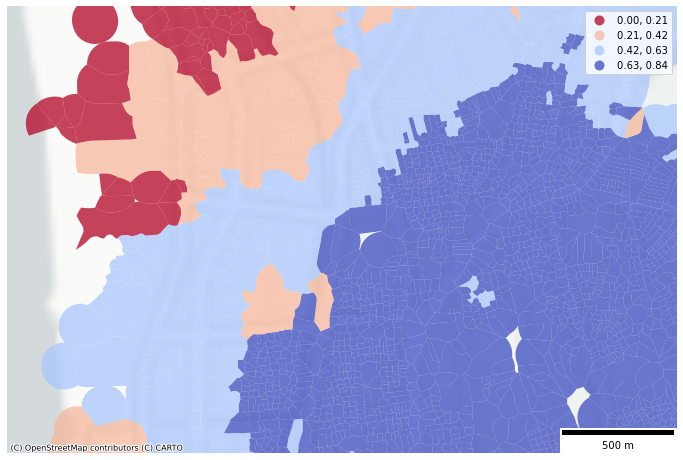

In [72]:
# generate static map
fig, ax1 = plt.subplots(figsize=(12,12))

ax1 = access_score_adults_tessels.plot(
    ax=ax1,
    column='access_score',
    scheme='equal_interval',
    k=4,
    cmap='coolwarm_r',
    markersize=(1),
    alpha=0.75,
    legend=True
)
ax1.set_xlim(333000, 336000)
ax1.set_ylim(392000, 394000)
ax1.set_axis_off()
ax1.add_artist(ScaleBar(1,location='lower right'))
contextily.add_basemap(ax1, crs=access_score_adults_tessels.crs.to_string(), 
                       zoom=12, 
                       source=contextily.providers.CartoDB.PositronNoLabels,
                       alpha=1.0
                       )
#plt.savefig('image1.png', dpi=1080, bbox_inches='tight')
